In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier 
from sklearn.preprocessing import robust_scale



In [2]:
df = pd.read_csv('Data_Cortex_Nuclear .csv')

In [3]:
df.dtypes

MouseID             object
DYRK1A_N           float64
ITSN1_N            float64
BDNF_N             float64
NR1_N              float64
NR2A_N             float64
pAKT_N             float64
pBRAF_N            float64
pCAMKII_N          float64
pCREB_N            float64
pELK_N             float64
pERK_N             float64
pJNK_N             float64
PKCA_N             float64
pMEK_N             float64
pNR1_N             float64
pNR2A_N            float64
pNR2B_N            float64
pPKCAB_N           float64
pRSK_N             float64
AKT_N              float64
BRAF_N             float64
CAMKII_N           float64
CREB_N             float64
ELK_N              float64
ERK_N              float64
GSK3B_N            float64
JNK_N              float64
MEK_N              float64
TRKA_N             float64
                    ...   
RRP1_N             float64
BAX_N              float64
ARC_N              float64
ERBB4_N            float64
nNOS_N             float64
Tau_N              float64
G

In [4]:
df.isnull().sum()

MouseID              0
DYRK1A_N             3
ITSN1_N              3
BDNF_N               3
NR1_N                3
NR2A_N               3
pAKT_N               3
pBRAF_N              3
pCAMKII_N            3
pCREB_N              3
pELK_N               3
pERK_N               3
pJNK_N               3
PKCA_N               3
pMEK_N               3
pNR1_N               3
pNR2A_N              3
pNR2B_N              3
pPKCAB_N             3
pRSK_N               3
AKT_N                3
BRAF_N               3
CAMKII_N             3
CREB_N               3
ELK_N               18
ERK_N                3
GSK3B_N              3
JNK_N                3
MEK_N                7
TRKA_N               3
                  ... 
RRP1_N               0
BAX_N                0
ARC_N                0
ERBB4_N              0
nNOS_N               0
Tau_N                0
GFAP_N               0
GluR3_N              0
GluR4_N              0
IL1B_N               0
P3525_N              0
pCASP9_N             0
PSD95_N    

In [5]:
#Impute missing protein expression values with a random value chosen from a normal distribution centered on the protein's mean
#expression value

for c in range(1, (len(df.columns.values))-4):
    df.iloc[:, c].fillna(np.random.normal(np.mean(df.iloc[:, c]), np.std(df.iloc[:, c])), inplace = True)
    


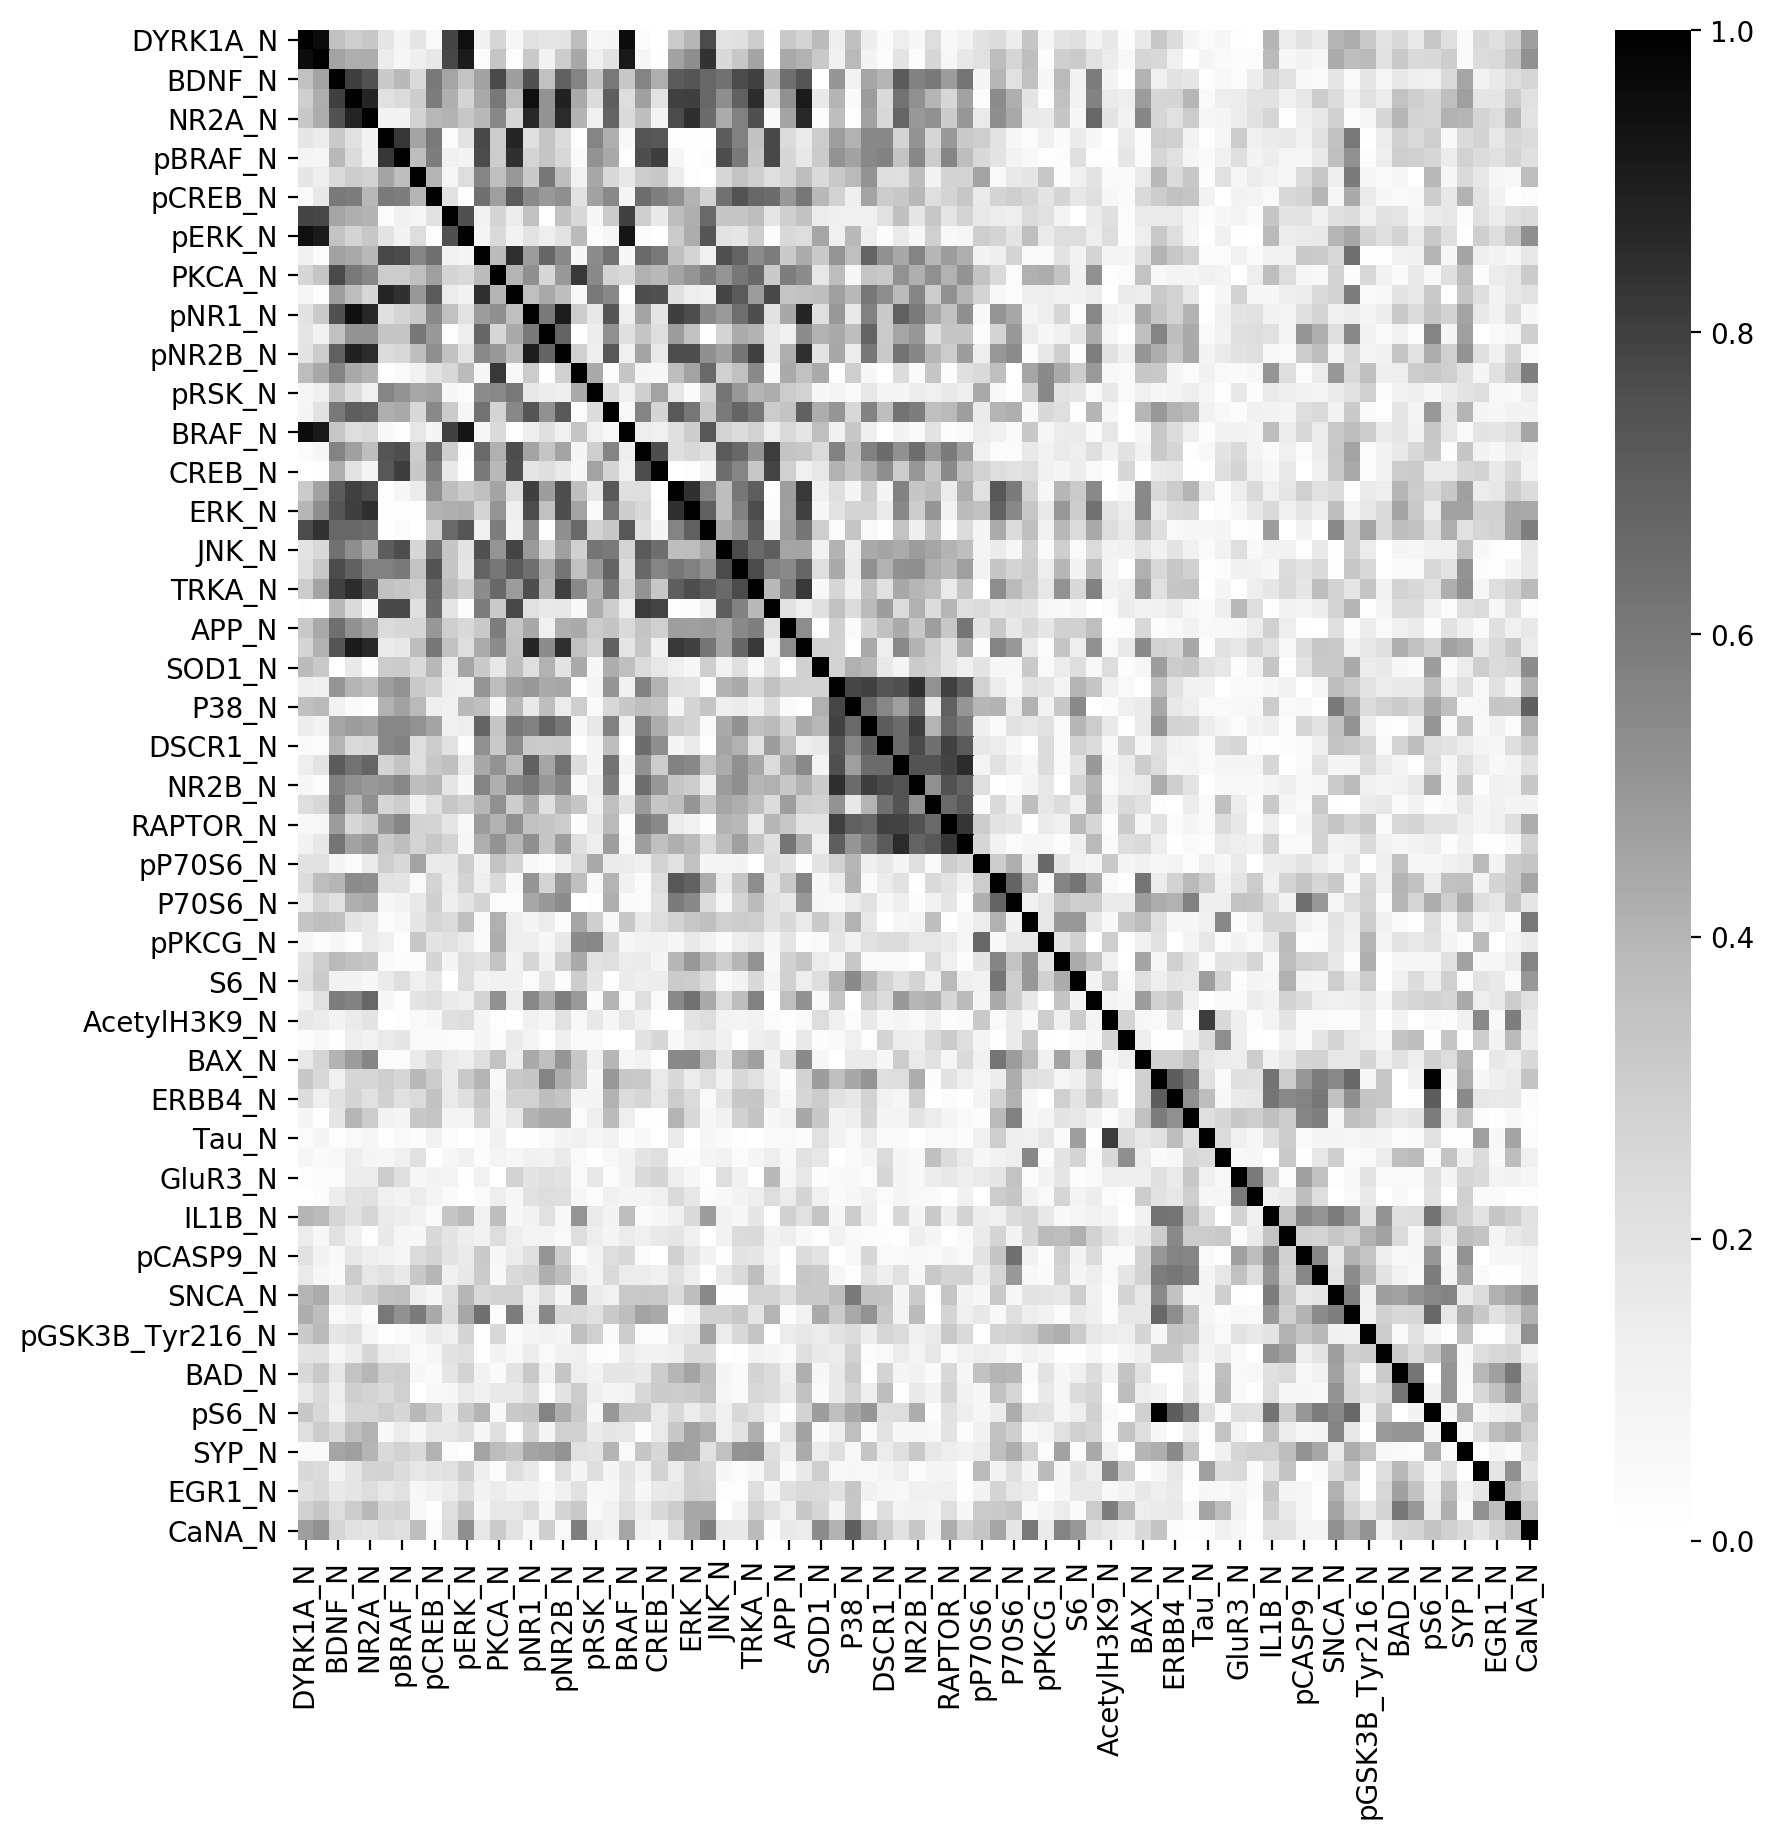

In [6]:
#How much collinearity exists among features?

correl = df.iloc[:, 1:-4].corr()

fig, ax = plt.subplots(figsize=(10,10), dpi = 200)
sns.heatmap(abs(correl), cmap = 'Greys', ax = ax)
plt.show()

In [7]:
df.Genotype.replace({'Control': 0, 'Ts65Dn': 1}, inplace = True)
df.Treatment.replace({'Memantine': 1, 'Saline': 0}, inplace = True)
df.Behavior.replace({'C/S': 0, 'S/C': 1}, inplace = True)
df['class'].replace({'c-CS-m': 0, 'c-SC-m': 1, 'c-CS-s': 2, 'c-SC-s': 3, 't-CS-m': 4, 't-SC-m': 5, 't-CS-s': 6, 't-SC-s': 7}, inplace = True)

In [8]:
#Standardize the data so that features values are on the same scale

robust_scale(df.iloc[:, 1:-4], copy = False)

array([[ 0.68754467,  0.79993759,  1.88109641, ..., -0.55662973,
        -1.25835086,  0.71017239],
       [ 0.74257267,  0.54278711,  1.57632022, ..., -0.50087613,
        -1.19312969,  0.84490116],
       [ 0.71532248,  0.72497102,  1.68459322, ..., -0.53017785,
        -1.27512876,  1.20734496],
       ...,
       [-0.69123679, -0.75727959, -1.36550586, ...,  1.08257012,
         3.78989586,  0.22478987],
       [-0.72863263, -0.67891305, -1.20229502, ...,  1.45488552,
         4.0153747 ,  0.17166983],
       [-0.32051435, -0.46584452, -0.99380848, ...,  1.48312984,
         4.0137034 ,  0.10618268]])

In [9]:
'''
Expression of one protein is unlikely independent of expression of another, so naive Bayes-type models probably would 
not work. 

Because there is considerable collinearity among some of the gene expression features, I'll try a ridge classifier to 
ensure the explained variance is not inflated by multicollinearity.

Because I want to iterate this ridge classifier over the three different outcome variables (genotype, treatment, and behavior)
I will make this process cleaner by writing a function that returns the ridge classifier score on randomly assigned test cases,
and also returns a list of all correctly predicted responses.
'''

def ridgeclass(X_tr, X_te, y_tr, y_te):
    rc = RidgeClassifier(alpha = 5)
    rc.fit(X_tr, y_tr)
    pred = rc.predict(X_te)
    correct = []
    incorrect = []
    for i in range(len(y_te)):
        if pred[i] == y_te.iloc[i]:
            correct.append(i)
        if pred[i] != y_te.iloc[i]:
            incorrect.append(i)
    return (rc.score(X_tr, y_tr), incorrect)

In [10]:
#Now I'll make separate training and test cases for each of the three response variables we're testing

xtrains = []
xtests = []
ytrains = []
ytests = []
for y in range(-4,0):
    X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:-4],df.iloc[:, y], test_size=0.20, random_state=42)
    xtrains.append(X_train)
    xtests.append(X_test)
    ytrains.append(y_train)
    ytests.append(y_test)

In [11]:
#Scores and proportions predicted correctly for each independent model

print('Genotype fit score and proportion predicted correctly in test set:')
print(ridgeclass(X_train, X_test, ytrains[0], ytests[0])[0], 
      1 - len(ridgeclass(X_train, X_test, ytrains[0], ytests[0])[1])/len(y_test))

print('Treatment fit score and proportion predicted correctly in test set:')
print(ridgeclass(X_train, X_test, ytrains[1], ytests[1])[0],
      1 - len(ridgeclass(X_train, X_test, ytrains[1], ytests[1])[1])/len(y_test))

print('Behavior fit score and proportion predicted correctly in test set') #It looks from the output like the model seriously overfits the behavior data
print(ridgeclass(X_train, X_test, ytrains[2], ytests[2])[0],
      1 - len(ridgeclass(X_train, X_test, ytrains[2], ytests[2])[1])/len(y_test))

print('Class fit score and proportion predicted correctly in test set')
print(ridgeclass(X_train, X_test, ytrains[3], ytests[3])[0],
      1 - len(ridgeclass(X_train, X_test, ytrains[3], ytests[3])[1])/len(y_test))



Genotype fit score and proportion predicted correctly in test set:
0.9398148148148148 0.9675925925925926
Treatment fit score and proportion predicted correctly in test set:
0.7928240740740741 0.7638888888888888
Behavior fit score and proportion predicted correctly in test set
1.0 1.0
Class fit score and proportion predicted correctly in test set
0.8761574074074074 0.8657407407407407


In [12]:
#What happens if we assign different lambda values to the ridge classification model? How does that impact fit and accuracy?

from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:-4],df.iloc[:, -1], test_size=0.20, random_state=42)

ridge_fits = []
ridge_accuracies = []

for l in range(1,10):
    ridge = RidgeClassifier(alpha = l)
    ridge.fit(X_train, y_train)
    ridge_fits.append(ridge.score(X_train, y_train))
    ridge_accuracies.append(accuracy_score(y_test, ridge.predict(X_test)))
    
print(ridge_fits, ridge_accuracies)
print('Avg fit score: {}'.format(np.mean(ridge_fits)))
print('Avg accuracy: {}'.format(np.mean(ridge_accuracies)))
    

[0.9618055555555556, 0.9293981481481481, 0.9108796296296297, 0.8912037037037037, 0.8761574074074074, 0.8645833333333334, 0.8541666666666666, 0.8460648148148148, 0.8356481481481481] [0.9398148148148148, 0.9166666666666666, 0.9074074074074074, 0.8703703703703703, 0.8657407407407407, 0.8564814814814815, 0.8472222222222222, 0.8333333333333334, 0.8333333333333334]
Avg fit score: 0.885545267489712
Avg accuracy: 0.8744855967078188


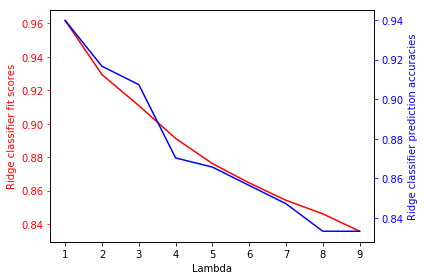

In [13]:
#Graphing the relationship between lambda and fit/accuracy in ridge models

lambdas = list(range(1,10))

fig, ax1 = plt.subplots()
ax1.plot(lambdas, ridge_fits, c = 'r')
ax1.set_xlabel('Lambda')
ax1.set_ylabel('Ridge classifier fit scores', color='r')
ax1.tick_params('y', colors='r')

ax2 = ax1.twinx()
ax2.plot(lambdas, ridge_accuracies, c = 'b')
ax2.set_ylabel('Ridge classifier prediction accuracies', color='b')
ax2.tick_params('y', colors='b')

fig.tight_layout()

plt.show()

In [14]:
#Make a KNN classifier with the same train and test data

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)

print(knn.score(X_train, y_train))
knnpred = knn.predict(X_test)
print(accuracy_score(y_test, knnpred))

0.9143518518518519
0.8796296296296297


In [15]:
#How does changing the number of neighbors included in classification influence the KNN model fit and predictions?

knn_fits = []
knn_accuracies = []

for n in range(1,21):
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_train, y_train)
    knn_fits.append(knn.score(X_train, y_train))
    knn_accuracies.append(accuracy_score(y_test, knn.predict(X_test)))
    
print(knn_fits, knn_accuracies)
print('Avg fit score: {}'.format(np.mean(knn_fits)))
print('Avg accuracy: {}'.format(np.mean(knn_accuracies)))

[1.0, 0.9930555555555556, 0.9930555555555556, 0.9837962962962963, 0.9803240740740741, 0.9641203703703703, 0.9560185185185185, 0.9409722222222222, 0.9282407407407407, 0.9143518518518519, 0.9074074074074074, 0.8854166666666666, 0.8819444444444444, 0.8680555555555556, 0.8611111111111112, 0.8460648148148148, 0.8425925925925926, 0.8298611111111112, 0.8217592592592593, 0.8078703703703703] [0.9953703703703703, 0.9814814814814815, 0.9861111111111112, 0.9444444444444444, 0.9490740740740741, 0.9212962962962963, 0.9259259259259259, 0.8842592592592593, 0.8888888888888888, 0.8796296296296297, 0.8657407407407407, 0.8564814814814815, 0.8472222222222222, 0.8472222222222222, 0.8425925925925926, 0.8287037037037037, 0.8194444444444444, 0.8055555555555556, 0.7962962962962963, 0.7824074074074074]
Avg fit score: 0.9103009259259259
Avg accuracy: 0.8824074074074076


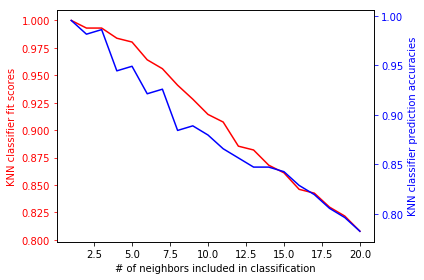

In [16]:
#Graph the relationship between number of neighbors and fit/predictive accuracy of KNN models

neighbors = list(range(1,21))

fig, ax1 = plt.subplots()
ax1.plot(neighbors, knn_fits, c = 'r')
ax1.set_xlabel('# of neighbors included in classification')
ax1.set_ylabel('KNN classifier fit scores', color='r')
ax1.tick_params('y', colors='r')

ax2 = ax1.twinx()
ax2.plot(neighbors, knn_accuracies, c = 'b')
ax2.set_ylabel('KNN classifier prediction accuracies', color='b')
ax2.tick_params('y', colors='b')

fig.tight_layout()

plt.show()

In [17]:
#Establish a random forest classifier fit to the same training data as above

from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:-4], 
                                                    df.iloc[:, -1], test_size=0.20, random_state = 42)

rf1 = RandomForestClassifier(n_estimators=100, max_depth=4, 
                             criterion = 'entropy').fit(X_train, y_train)

print(rf1.score(X_train, y_train))
rfpred = rf1.predict(X_test)
print(accuracy_score(y_test, rfpred))

0.9398148148148148
0.8611111111111112


In [37]:
#How does modifying max depth influence fit and predictive accuracy of random forest models

rf_fits = []
rf_accuracies = []

for d in range(2,6):
    rf = RandomForestClassifier(n_estimators=100, max_depth=d, criterion = 'entropy')
    rf.fit(X_train, y_train)
    rf_fits.append(rf.score(X_train, y_train))
    rf_accuracies.append(accuracy_score(y_test, rf.predict(X_test)))
    
print(rf_fits, rf_accuracies)
print('Avg fit score: {}'.format(np.mean(rf_fits)))
print('Avg accuracy: {}'.format(np.mean(rf_accuracies)))

[0.5578703703703703, 0.7361111111111112, 0.8842592592592593, 0.9583333333333334] [0.5416666666666666, 0.6666666666666666, 0.7916666666666666, 0.8564814814814815]
Avg fit score: 0.7841435185185185
Avg accuracy: 0.7141203703703703


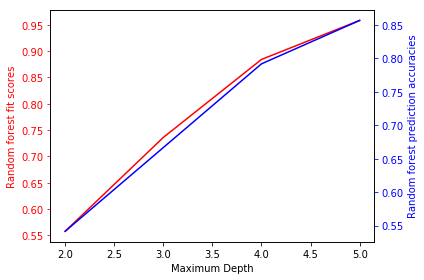

In [38]:
#Graph the relationship between max depth and fit/predictive accuracy of random forest models

depth = list(range(2,6))

fig, ax1 = plt.subplots()
ax1.plot(depth, rf_fits, c = 'r')
ax1.set_xlabel('Maximum Depth')
ax1.set_ylabel('Random forest fit scores', color='r')
ax1.tick_params('y', colors='r')

ax2 = ax1.twinx()
ax2.plot(depth, rf_accuracies, c = 'b')
ax2.set_ylabel('Random forest prediction accuracies', color='b')
ax2.tick_params('y', colors='b')

fig.tight_layout()

plt.show()

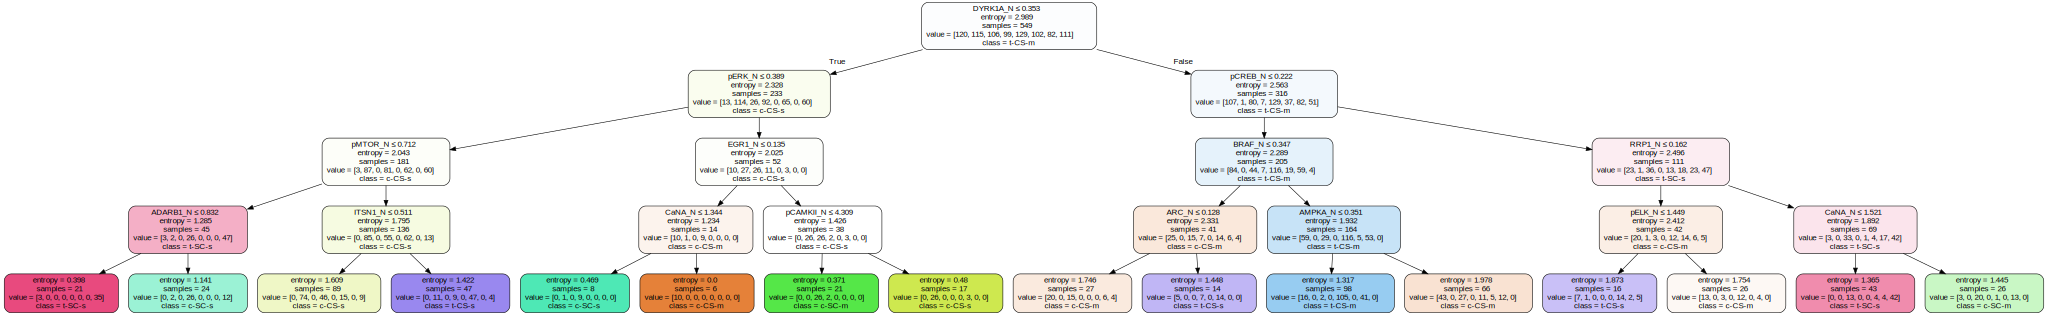

In [20]:
from sklearn import tree
import graphviz


#Look at a random tree in the random forest
tree1 = rf1.estimators_[1]

dot_data = tree.export_graphviz(tree1, out_file= None, feature_names=df.iloc[:, 1:-4].columns.values,
                                class_names = ['c-CS-m', 'c-CS-s', 'c-SC-m', 'c-SC-s', 't-CS-m', 't-CS-s', 't-SC-m', 't-SC-s'], filled=True, rounded=True, special_characters=True)  
graph1 = graphviz.Source(dot_data)  
graph1 

In [21]:
from sklearn.multioutput import ClassifierChain

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:-4], 
                                                    df.iloc[:, -4:-1], test_size=0.20, random_state = 42)

#Create a series of chain classifiers with the order of the outcome variables randomly selected among trials:

chains = [ClassifierChain(RidgeClassifier(alpha = 5), order = 'random', random_state=i) for i in range(5)]
fits_chainclass = [c.fit(X_train, y_train) for c in chains]

Y_preds_chainclass = np.array([c.predict(X_test) for c in chains])
scores_chainclass = np.array([c.score(X_train, y_train) for c in chains])


#Re-arrange the random results so that the outcome variables appear in the same order each trial

genotype_pred = []
treatment_pred = []
behavior_pred = []

for i in range(5):
    for c in range(3):
        for x in range(len(y_test)):
            if chains[i].order_[c] == 0:
                genotype_pred.append(Y_preds_chainclass[i,x,c])
            elif chains[i].order_[c] == 1:
                treatment_pred.append(Y_preds_chainclass[i,x,c])
            else:
                behavior_pred.append(Y_preds_chainclass[i,x,c])


genotype_pred = np.array(genotype_pred).reshape(len(y_test), 5)
treatment_pred = np.array(treatment_pred).reshape(len(y_test), 5)
behavior_pred = np.array(behavior_pred).reshape(len(y_test), 5)


#Get most common predicted classification among the 5 trials for each value in the test set, and compare to correct
#classification


import statistics 

genotype_correct = []
treatment_correct = []
behavior_correct = []

#Get the correct predictions for genotype
for i in range(len(y_test)):
    if statistics.mode(genotype_pred[i, 0:5]) == y_test.iloc[i, 0]:
        genotype_correct.append(i)
            
#Get the correct predictions for treatment
for i in range(len(y_test)):
    if statistics.mode(treatment_pred[i, 0:5]) == y_test.iloc[i, 1]:
        treatment_correct.append(i)
            
#Get the correct predictions for behavior
for i in range(len(y_test)):
    if statistics.mode(behavior_pred[i, 0:5]) == y_test.iloc[i, 2]:
        behavior_correct.append(i)
        
print('Scores using classifier chain method: {}'.format(scores_chainclass))
print('Average score using classifier chain method: {}'.format(np.mean(scores_chainclass)))
print('proportion of correct predictions using chain classifier method: {} (genotype), {} (treatment), {} (behavior)'.format(
    len(genotype_correct)/len(y_test), len(treatment_correct)/len(y_test), len(behavior_correct)/len(y_test)))

Scores using classifier chain method: [0.82523148 0.82060185 0.82523148 0.74768519 0.74768519]
Average score using classifier chain method: 0.7932870370370371
proportion of correct predictions using chain classifier method: 0.4722222222222222 (genotype), 0.48148148148148145 (treatment), 0.5277777777777778 (behavior)


In [22]:
orders = []

for i in range(5):
    orders.append(chains[i].order_)
    
first_in_chain = []



From the printout above it appears that beginning the classifier chain with 'behavior' or with 'genotype' increases the fit of the model, whereas beginning the chain with 'treatment' leads to poor fit. It also seems that, despite the fairly strong fit overall, the predictive power of the model is relatively weak. 

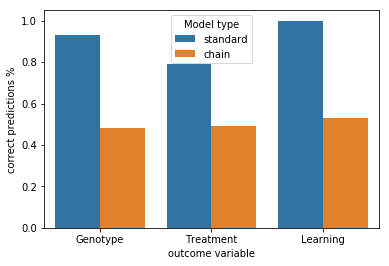

In [23]:
''''
Genotype fit score and proportion predicted correctly in test set:
0.9386574074074074 0.9722222222222222
Treatment fit score and proportion predicted correctly in test set:
0.7881944444444444 0.7685185185185185
Behavior fit score and proportion predicted correctly in test set
1.0 1.0
Class fit score and proportion predicted correctly in test set
0.8773148148148148 0.8657407407407407

'''

df_predictions = pd.DataFrame()
df_predictions['correct predictions %'] = [0.93, 0.79, 1.0, .48, .49, .53] 
df_predictions['outcome variable'] = ['Genotype', 'Treatment', 'Learning', 'Genotype', 'Treatment', 'Learning']
df_predictions['Model type'] = ['standard', 'standard', 'standard', 'chain', 'chain', 'chain']
sns.barplot(x = df_predictions['outcome variable'], y = df_predictions['correct predictions %'], hue = df_predictions['Model type'])
plt.show()

ClassifierChain(base_estimator=RidgeClassifier(alpha=5, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001),
        cv=None, order=[0, 1, 2], random_state=None) ClassifierChain(base_estimator=RidgeClassifier(alpha=5, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001),
        cv=None, order=[0, 2, 1], random_state=None) ClassifierChain(base_estimator=RidgeClassifier(alpha=5, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001),
        cv=None, order=[1, 0, 2], random_state=None) ClassifierChain(base_estimator=RidgeClassifier(alpha=5, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001),
        cv=None, order=[1, 2, 0],

Text(0, 0.5, 'predictive accuracy\n(% correctly predicted)')

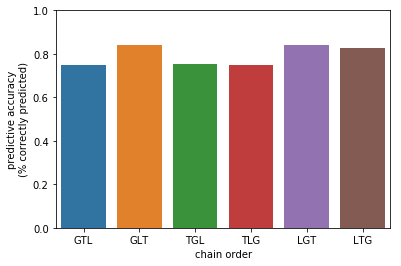

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:-4], 
                                                    df.iloc[:, -4:-1], test_size=0.20, random_state = 42)

chain1 = ClassifierChain(RidgeClassifier(alpha = 5), order = [0,1,2]).fit(X_train,y_train)
chain2 = ClassifierChain(RidgeClassifier(alpha = 5), order = [0,2,1]).fit(X_train,y_train)
chain3 = ClassifierChain(RidgeClassifier(alpha = 5), order = [1,0,2]).fit(X_train,y_train)
chain4 = ClassifierChain(RidgeClassifier(alpha = 5), order = [1,2,0]).fit(X_train,y_train)
chain5 = ClassifierChain(RidgeClassifier(alpha = 5), order = [2,0,1]).fit(X_train,y_train)
chain6 = ClassifierChain(RidgeClassifier(alpha = 5), order = [2,1,0]).fit(X_train,y_train)

p1 = chain1.predict(X_test)
p2 = chain2.predict(X_test)
p3 = chain3.predict(X_test)
p4 = chain4.predict(X_test)
p5 = chain5.predict(X_test)
p6 = chain6.predict(X_test)

a1 = accuracy_score(p1, y_test)
a2 = accuracy_score(p2, y_test)
a3 = accuracy_score(p3, y_test)
a4 = accuracy_score(p4, y_test)
a5 = accuracy_score(p5, y_test)
a6 = accuracy_score(p6, y_test)

print(chain1, chain2, chain3, chain4, chain5, chain6)


sns.barplot(x = ['GTL', 'GLT', 'TGL', 'TLG', 'LGT', 'LTG'], y = [a1, a2, a3, a4, a5, a6])
plt.ylim(0.0, 1.0)
plt.xlabel('chain order')
plt.ylabel('predictive accuracy\n(% correctly predicted)')
